###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2017 L.A. Barba, N.C. Clementi

# Bird's-eye view of mechanical vibrations

Welcome to **Lesson 4** of the third module in _Engineering Computations_. This course module is dedicated to studying the dynamics of change with computational thinking, Python and Jupyter.
The first three lessons give you a solid footing to tackle problems involving motion, velocity, and acceleration. They are:

1. [Lesson 1](http://go.gwu.edu/engcomp3lesson1): Catch things in motion
2. [Lesson 2](http://go.gwu.edu/engcomp3lesson2): Step to the future
3. [Lesson 3](http://go.gwu.edu/engcomp3lesson3): Get with the oscillations

You learned to compute velocity and acceleration from position data, using numerical derivatives, and to capture position data of moving objects from images and video. For physical contexts we used free-fall of a ball, and projectile motion. Then you faced the opposite challenge: computing velocity and position from acceleration data, leading to the idea of stepping forward in time to solve a differential equation. 

Our general approach combines these key ideas: (1) turning a second-order differential equation into a system of first-order equations; (2) writing the system in vector form, and the solution in terms of a state vector; (3) designing a code to obtain the solution using separate functions to compute the derivatives of the state vector, and to step the system in time with a chosen scheme (e.g., Euler, Euler-Cromer, Runge-Kutta). It's a rock-steady approach that will serve you well!

In this lesson, you'll get a broader view of applying your new-found skills to learn about mechanical vibrations: a classic engineering problem. You'll study general spring-mass systems with damping and a driving force, and appreciate the diversity of behaviors that arise. We'll end the lesson presenting a powerful method to study dynamical systems: visualizing direction fields and trajectories in the phase plane.

Are you ready? Start by loading the Python libraries that we know and love.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
rcParams['mathtext.fontset'] = 'cm' # set Computer Modern for LaTeX math

## General spring-mass system

The simplest mechanical oscillating system is a mass $m$ attached to a spring, without friction. We discussed this system in the [previous lesson](http://go.gwu.edu/engcomp3lesson3). In general, though, these systems are subject to friction—represented by a mechanical damper—and a driving force. Also, the spring's restoring force could be a nonlinear function of position, $k(x)$.

<img src="images/damped-spring.png" style="width: 500px;"/> 
#### General spring-mass system, with driving and damping.

Newton's law applied to the general (driven, damped, nonlinear) spring-mass system is:

\begin{equation}
 m \ddot{x} = F(t) -b(\dot{x}) - k(x)
\end{equation}

where
* $F(t)$ is the driving force
* $b(\dot{x})$ is the damping force
* $k(x)$ is the restoring force, possibly nonlinear

Written as a system of two differential equations, we have:

\begin{eqnarray}
\dot{x} &=& v, \nonumber\\
\dot{v} &=& \frac{1}{m} \left( F(t) - k(x) - b(v) \right).
\end{eqnarray}

With the state vector,
\begin{equation}
\mathbf{x} = \begin{bmatrix}
x \\ v
\end{bmatrix},
\end{equation}

the differential equation in vector form is:

\begin{equation}
\dot{\mathbf{x}} = \begin{bmatrix}
v \\ \frac{1}{m} \left( F(t) - k(x) - b(v) \right)
\end{bmatrix}.
\end{equation}

In this more general system, the time variable could appear explicitly on the right-hand side, via the driving function $F(t)$. We'll need to adapt the code for the time-stepping function to take the time as an additional argument. 

For example, the `euler_cromer()` function we defined in the previous lesson took three arguments: `state, rhs, dt`—the state vector, the Python function computing the right-hand side of the differential equation, and the time step. Let's re-work that function now to take an additional `time` variable, which also gets used in the `rhs` function.

In [2]:
# new version of the function, taking time as explicit argument
def euler_cromer(state, rhs, time, dt):
    '''Update a state to the next time increment using Euler-Cromer's method.
    
    Arguments
    ---------
    state : state vector of dependent variables
    rhs   : function that computes the RHS of the DE, taking (state, time)
    time  : float, time instant
    dt    : float, time step
    
    Returns
    -------
    next_state : state vector updated after one time increment'''
    
    mid_state = state + rhs(state, time)*dt # Euler step
    mid_derivs = rhs(mid_state, time)       # update derivatives
    
    next_state = numpy.array([mid_state[0], state[1] + mid_derivs[1]*dt])
    
    return next_state

### Case with linear damping

Let's look at the behavior of a system with linear restoring force, linear damping, but no driving force: $k(x)= kx$, $b(v)=bv$, $F(t)=0$.
The differential system is now:


\begin{equation}
\dot{\mathbf{x}} = \begin{bmatrix}
v \\ \frac{1}{m} \left( - kx - bv \right)
\end{bmatrix}.
\end{equation}

Now we need to write a function to compute the right-hand side (derivatives) for this system.
Even though the system does not explicitly use the time variable in the right-hand side, we still include `time` as an argument to the function, so that it is consistent with our new design for the `euler_cromer()` step. We include `time` in the arguments list, but it is not used inside the function code. It's thus a good idea to specify a _default value_ for this argument by writing `time=0` in the arguments list: that will allow us to also call the function leaving the `time` argument blank, if we wanted to (in which case, it will automatically be assigned its default value of 0).
Another option for the default value is `time=None`. It doesn't matter because the variable is not used inside the function!

In [3]:
def dampedspring(state, time=0):
    '''Computes the right-hand side of the spring-mass differential 
    equation, with linear damping.
    
    Arguments
    --------- 
    state : state vector of two dependent variables
    time : float, time instant
    
    Returns 
    -------
    derivs: derivatives of the state vector
    '''
    
    derivs = numpy.array([state[1], 1/m*(-k*state[0]-b*state[1])])
    return derivs

Let's try it!
The following example is from section 4.3.9 of Ref. [1] (an open-access text!). 
We set the model parameters, the initial conditions, and the time-stepping conditions.
Then we initialize the numerical solution array `num_sol`, and call the `euler_cromer()` function in the `for` statement.
Notice that we pass the time instant `t[i]` to the function's `time` argument (which will allow us to use the same calling signature when we solve for a system with driving force).

In [4]:
m = 1.0
k = 1.0
b = 0.3

In [5]:
x0 = 1    # initial position
v0 = 0    # initial velocity

In [6]:
T = 12*numpy.pi
N = 5000
dt = T/N

t = numpy.linspace(0, T, N)

In [7]:
num_sol = numpy.zeros([N,2]) #initialize solution array

#Set intial conditions
num_sol[0,0] = x0
num_sol[0,1] = v0

In [8]:
for i in range(N-1):
    num_sol[i+1] = euler_cromer(num_sol[i], dampedspring, t[i], dt)

Time to plot the solution—in our plot of position versus time below, notice that we added a line with [`pyplot.figtext()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.figtext.html?highlight=matplotlib%20pyplot%20figtext#matplotlib.pyplot.figtext) at the end. This command adds a custom text to the figure: we use it to print the values of the spring-mass model parameters corresponding to the plot. See how we print the parameter values in the text string? We used Python's string formatter, which you learned about in [Module 2 Lesson 1](http://go.gwu.edu/engcomp2lesson1).
If we were to re-run the solution with different model parameters, re-executing the code in this cell would update the plot and the text with the proper values. (We don't want to rely on manually changing the text, as that is error prone!)

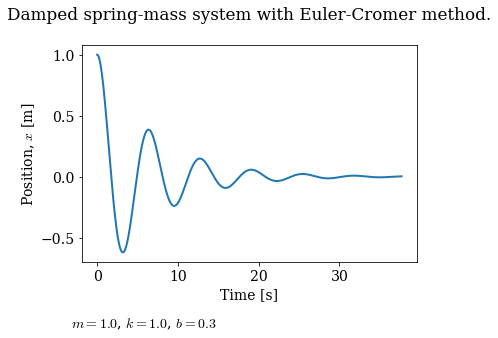

In [9]:
fig = pyplot.figure(figsize=(6,4))

pyplot.plot(t, num_sol[:, 0], linewidth=2, linestyle='-')
pyplot.xlabel('Time [s]')
pyplot.ylabel('Position, $x$ [m]')
pyplot.title('Damped spring-mass system with Euler-Cromer method.\n')
pyplot.figtext(0.1,-0.1,'$m={:.1f}$, $k={:.1f}$, $b={:.1f}$'.format(m,k,b));

The result above shows that the oscillations die down over a few periods: the oscillations are _damped_ over time.
And our plot looks pretty close to [Fig. 4.27](https://link.springer.com/chapter/10.1007%2F978-3-319-32428-9_4#Fig27) of Ref. [1], as it should.

### Case with sinusoidal driving, and damping

Suppose now that an external force of the form $F(t) = A \sin(\omega t)$ drives the system. This is a typical situation in mechanical systems. Let's find out what a system like that behaves like. The example below comes from section 4.3.10 of Ref. [1].

We're showy, so we decided to use the Unicode character for the Greek letter $\omega$ in the code… because we can! 
With a handy table of [Unicode for greek letters](https://gist.github.com/beniwohli/765262), you can pick a symbol code, type it into a code cell, and out comes the symbol. Then, it's a copy-and-paste job to reuse the symbol in the code. And using greek letters for some variable names is very chic.

In [10]:
u'\u03C9'

'ω'

In [11]:
A = 0.5  # parameter values from example in 4.3.10 of Ref. [1]
ω = 3

More than showy, we're snazzy, and so we build a one-line function using the [`lambda`](https://docs.python.org/3/reference/expressions.html#lambda) keyword.
It's just too cool.
In Python, you can create a small function in one line using the assignment operator `=`, followed by the `lambda` keyword, then a statement of the form `arguments: expression`—in our case, we have the single argument `time`, and the expression is the sinusoidal driving.
The sine mathematical function is avaible to us from the [`math` library](https://docs.python.org/3/library/math.html). Check it out.

In [12]:
from math import sin
F = lambda time: A*sin(ω*time)

This is really a function: we can call `F()` at any point in our code, passing a value of time, and it will output the result of $F(t) = A \sin(\omega t)$.

Now, let's write the right-hand side function of derivatives for the driven spring-mass system (with damping). Notice that we use the lambda function `F()` inside this new function, and the `time` variable explicitly as the argument to `F()`. Some powerful Python kung fu!

In [13]:
def drivenspring(state, time):
    '''Computes the right-hand side of the spring-mass differential 
    equation, with sinusoidal driving and linear damping.
    
    Arguments
    --------- 
    state : state vector of two dependent variables
    time : float, time instant
    
    Returns 
    -------
    derivs: derivatives of the state vector
    '''
      
    derivs = numpy.array([state[1], 1/m*(F(time)-k*state[0]-b*state[1])])
    return derivs

Here is where the power of our code design becomes clear: solving the differential equation via time-stepping inside a `for` statement looks just like before, with the only difference being that we pass another right-hand-side function of derivatives.
The code cell below solves the driven spring-mass system with the same model parameters we used for the damped system without driving.

In [14]:
for i in range(N-1):
    num_sol[i+1] = euler_cromer(num_sol[i], drivenspring, t[i], dt)

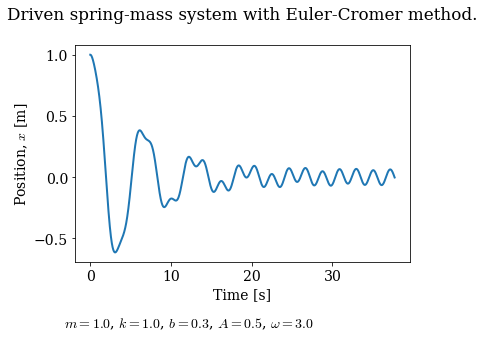

In [15]:
fig = pyplot.figure(figsize=(6,4))

pyplot.plot(t, num_sol[:, 0], linewidth=2, linestyle='-')
pyplot.xlabel('Time [s]')
pyplot.ylabel('Position, $x$ [m]')
pyplot.title('Driven spring-mass system with Euler-Cromer method.\n')
pyplot.figtext(0.1,-0.1,'$m={:.1f}$, $k={:.1f}$, $b={:.1f}$, $A={:.1f}$, $\omega={:.1f}$'.format(m,k,b,A,ω));

And our result looks just like [Fig. 4.28](https://link.springer.com/chapter/10.1007%2F978-3-319-32428-9_4#Fig28) of Ref. [1], as it should. You can see that the system starts out dominated by the spring-mass oscillations, which get damped over time and the effect of the external driving becomes visible, and the sinusoidal driving is all that is left in the end.

##### Exercise:

* Experiment with different values of the driving-force amplitude, $A$, and frequency, $\omega$.
* Swap the sine driving for a cosine, and see what happens.

An interesting behavior occurs when the damping is low enough and the frequency of the driving force coincides with the natural frequency of the mass-spring system, $\sqrt{k/m}$: **resonance**.

Try these parameters:

In [16]:
ω = 1
b = 0.1

In [17]:
for i in range(N-1):
    num_sol[i+1] = euler_cromer(num_sol[i], drivenspring, t[i], dt)

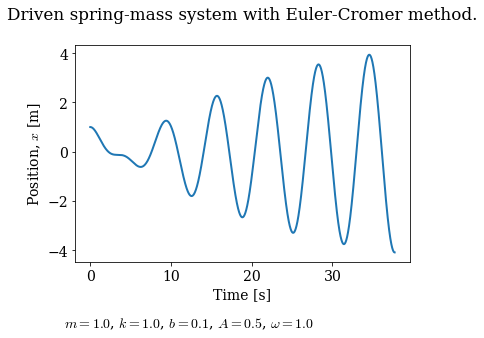

In [18]:
fig = pyplot.figure(figsize=(6,4))

pyplot.plot(t, num_sol[:, 0], linewidth=2, linestyle='-')
pyplot.xlabel('Time [s]')
pyplot.ylabel('Position, $x$ [m]')
pyplot.title('Driven spring-mass system with Euler-Cromer method.\n')
pyplot.figtext(0.1,-0.1,'$m={:.1f}$, $k={:.1f}$, $b={:.1f}$, $A={:.1f}$, $\omega={:.1f}$'.format(m,k,b,A,ω));

As you can see, the amplitude of the oscillations grow over time! (Compare the vertical axis of this plot with the previous one.) Our result matches with [Fig. 4.29](https://link.springer.com/chapter/10.1007%2F978-3-319-32428-9_4#Fig29) of Ref. [1].

## Solutions on the phase plane

The spring-mass system, as you see, can behave in various ways. If the spring is linear, and there is no damping or driving (like in the previous lesson), the motion is periodic. If we add damping, the oscillatory motion decays over time. With driving, the motion can be rather more complicated, and sometimes can exhibit resonance.

Each of these types of motion is represented by corresponding solutions to the differential system, dictated by the model parameters and the initial conditions.

How could we get a sense for all the types of solutions to a differential system?
A powerful method to do this is to use the _phase plane_.

A system of two first-order differential equations:

\begin{eqnarray}
\dot{x}(t) &=& f(x, y) \\
\dot{y}(t) &=& g(x, y)
\end{eqnarray}


with state vector

\begin{equation}
\mathbf{x} = \begin{bmatrix}
x \\ y
\end{bmatrix},
\end{equation}

is called a _planar autonomous system_: planar, because the state vector has two components; and autonomous (self-generating), because the time variable does not explicitly appear on the right-hand side
(which wouldn't apply to the driven spring-mass system).


For initial conditions $\mathbf{x}_0=(x_0, y_0)$, the system has a unique solution $\mathbf{x}(t)=\left(x(t), y(t)\right)$. This solution can be represented by a planar curve on the $xy$-plane—the **phase plane**—and is called a _trajectory_ of the system.

On the phase plane, we can plot a **direction (slope) field** by generating a uniform grid of points $(x_i, y_j)$ in some chosen range $(x_\text{min}, x_\text{max})\times(y_\text{min}, y_\text{max})$, and drawing small line segments representing the direction of the vector field $(f(x,y), g(x,y)$ on each point.

Let's draw a direction field for the damped spring-mass system, and include a solution trajectory. We copied the whole problem set-up below, to get a solution all in one code cell, for easy trial with different parameter choices.

In [19]:
m = 1
k = 1
b = 0.3

x0 = 3    # initial position
v0 = 3    # initial velocity

T = 12*numpy.pi
N = 5000
dt = T/N

t = numpy.linspace(0, T, N)
num_sol = numpy.zeros([N,2]) #initialize solution array

#Set intial conditions
num_sol[0,0] = x0
num_sol[0,1] = v0

for i in range(N-1):
    num_sol[i+1] = euler_cromer(num_sol[i], dampedspring, t[i], dt)

To choose a range for the plotting area of the direction field, let's look at the maximum values of the solution array.

In [20]:
numpy.max(num_sol[:,0])

4.0948277569088525

In [21]:
numpy.max(num_sol[:,1])

3.0

With that information, we choose the plotting area as $(-4,4)\times(-4,4)$. Below, we'll create an array named `coords` to hold the positions of mesh lines on each coordinate direction. Here, we pick 11 mesh points in each direction.

Then, we'll call the very handy [`meshgrid()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.meshgrid.html) function of NumPy—you should definitely study the documentation and use pen and paper to diligently figure out what it does!

The outputs of `meshgrid()` are two matrices holding the $x$ and $y$ coordinates, respectively, of points on the grid. Combined, these two matrices give the coordinate pairs of every grid point where we'll compute the direction field.

In [22]:
coords = numpy.linspace(-4,4,11)
X, Y = numpy.meshgrid(coords, coords)

Look at the vector form of the differential system again… with our two matrices of coordinate values for the grid points, we could compute the vector field on all these points in one go using array operations:

In [23]:
F = Y
G = 1/m * (-k*X -b*Y)

Matplotlib has a type of plot called [`quiver`](https://matplotlib.org/examples/pylab_examples/quiver_demo.html) that draws a vector field on a plane. Let's try it out using the vector field we computed above.

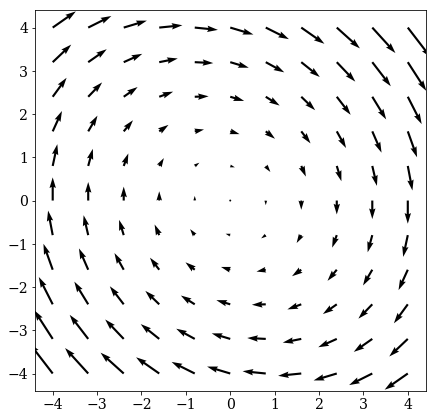

In [24]:
fig = pyplot.figure(figsize=(7,7))

pyplot.quiver(X,Y, F,G);

OK, that's not bad. The arrows on each grid point represent vectors $(f(x,y), g(x,y))$, computed from the right-hand side of the differential equation. 

_What are the axes on this plot?_ Well, they are the components of the state vector—which for the spring-mass system are _position_ and _velocity_. The vector field looks like a "flow" going around the origin, the values of position and velocity oscillating around. If you imagine an initial condition represented by a coordinate pair $(x_0,y_0)$, the solution trajectory would follow along the arrows, spiraling around the origin, while slowly approaching it.

We'd like to visualize a trajectory on the vector-field plot, and also improve it in a few ways. But before that, Python will astonish you with a splendid fact: you can also compute the vector field on the grid points by calling the function `dampedspring()`, passing as argument a list made of the matrices `X` and `Y`.

_Why does this work?_ Study the function and think!

In [25]:
F, G = dampedspring([X,Y])

The default behavior of `quiver` is to scale the vectors (arrows) with the magnitude, but direction fields are usually drawn using line segments of equal length. Also by default, the vectors are drawn _starting at_ the grid points, while direction fields ususally _center_ the line segments. We can improve our plot using by _scaling_ the vectors by their magnitude, and using the `pivot='mid'` option on the plot. A little transparency is also nice.

To plot the improved direction field below, we drew ideas from a tutorial available online, see Ref. [2]. To compute the magnitude of the vectors, we use the [`numpy.hypot()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.hypot.html) function, which returns the triangle hypotenuse of two right-angled sides.

We should also add axis labels and a title!

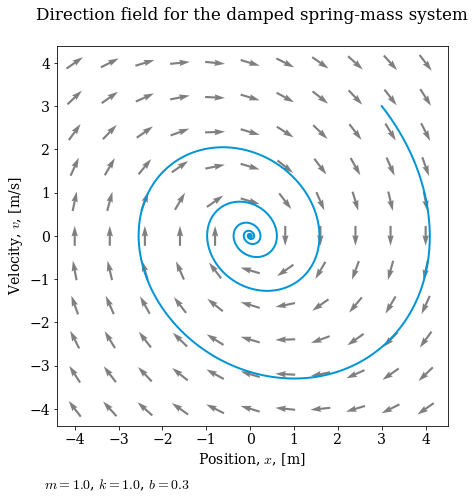

In [26]:
M = numpy.hypot(F,G)
M[ M == 0] = 1      # to avoid zero-division
F = F/M
G = G/M

fig = pyplot.figure(figsize=(7,7))

pyplot.quiver(X,Y, F,G, pivot='mid', alpha=0.5)
pyplot.plot(num_sol[:,0], num_sol[:,1], color= '#0096d6', linewidth=2)
pyplot.xlabel('Position, $x$, [m]')
pyplot.ylabel('Velocity, $v$, [m/s]')
pyplot.title('Direction field for the damped spring-mass system\n')
pyplot.figtext(0.1,0,'$m={:.1f}$, $k={:.1f}$, $b={:.1f}$'.format(m,k,b));

And just for kicks, let's re-do everything with zero damping:

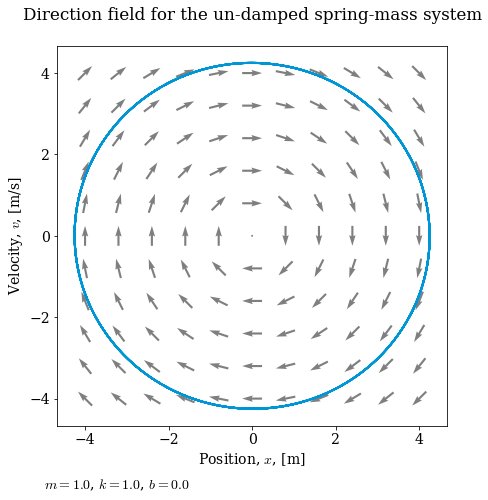

In [27]:
m = 1
k = 1
b = 0

x0 = 3    # initial position
v0 = 3    # initial velocity

T = 12*numpy.pi
N = 5000
dt = T/N

t = numpy.linspace(0, T, N)
num_sol = numpy.zeros([N,2]) #initialize solution array

#Set intial conditions
num_sol[0,0] = x0
num_sol[0,1] = v0

for i in range(N-1):
    num_sol[i+1] = euler_cromer(num_sol[i], dampedspring, t[i], dt)
    
F, G = dampedspring([X,Y])

M = numpy.hypot(F,G)
M[ M == 0] = 1      # to avoid zero-division
F = F/M
G = G/M

fig = pyplot.figure(figsize=(7,7))

pyplot.quiver(X,Y, F,G, pivot='mid', alpha=0.5)
pyplot.plot(num_sol[:,0], num_sol[:,1], color= '#0096d6', linewidth=2)
pyplot.xlabel('Position, $x$, [m]')
pyplot.ylabel('Velocity, $v$, [m/s]')
pyplot.title('Direction field for the un-damped spring-mass system\n')
pyplot.figtext(0.1,0,'$m={:.1f}$, $k={:.1f}$, $b={:.1f}$'.format(m,k,b));


##### Challenge task

* Write a function to draw direction fields as above, taking as arguments the right-hand-side derivatives function, and lists containing the plot limits and the number of grid lines in each coordinate direction.

* Write some code to capture mouse clicks on the direction field, following what you learned in [Lesson 1](http://go.gwu.edu/engcomp3lesson1) of this module.

* Use the captured mouse clicks as initial conditions and obtain the corresponding trajectories by solving the differential system, then make a new plot showing the trajectories with different colors.

## What we've learned

* General spring-mass systems have several behaviors: periodic in the undamped case, decaying oscillations when damped, complex oscillations when driven.
* Resonance appears when the driving frequency matches the natural frequency of the system.
* We can add formatted strings in figure titles, labels and added text.
* The `lambda` keyword builds one-line Python functions.
* The `meshgrid()` function of NumPy is handy for building a grid of points on a plane.
* State vectors of a differential system live on the _phase plane_.
* Solutions of the differential system (given initial conditions) are _trajectories_ on the phase plane.
* Trajectories for the undamped spring-mass system are circles; in the damped case, they are spirals toward the origin.

## References

1. Linge S., Langtangen H.P. (2016) Solving Ordinary Differential Equations. In: Programming for Computations - Python. Texts in Computational Science and Engineering, vol 15. Springer, Cham, https://doi.org/10.1007/978-3-319-32428-9_4, open access and reusable under [CC-BY-NC](http://creativecommons.org/licenses/by-nc/4.0/) license.
V
2. [Plotting direction fields and trajectories in the phase plane](http://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html?highlight=direction%20fields#Plotting-direction-fields-and-trajectories-in-the-phase-plane), as part of the Lotka-Volterra tutorial by Pauli Virtanen and Bhupendra, in the _SciPy Cookbook_. 

In [28]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../../style/custom.css'
HTML(open(css_file, "r").read())